# ImageSegmentNet-v1
* Separate ImageSegmentNet from 2DSegmentNet-v2 for clean implementation

# Initialization

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Model Definition

In [478]:
class ImageSegmentNet(nn.Module):
    def __init__(self, n_xsegments, n_ysegments):
        super(ImageSegmentNet, self).__init__()
        self.n_xsegments = n_xsegments
        self.n_ysegments = n_ysegments

        #Initialize x coordinates between 0-1 so segments are equal size
        self._custom_init(0, 1, 0, 1)

    def _custom_init(self, x_min, x_max, y_min, y_max):
        #Initialize x coordinates between so segments are equal size
        x_init = torch.Tensor(np.linspace(x_min, x_max, self.n_xsegments + 1))
        # make a 2D init tensor
        x_2dinit = torch.Tensor(self.n_ysegments + 1, self.n_xsegments + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))

        y_init = torch.Tensor(np.linspace(y_min, y_max, self.n_ysegments + 1))
        # make a 2D init tensor
        y_2dinit = torch.Tensor(self.n_ysegments + 1, self.n_xsegments + 1)
        # Update the x_2dinit tensor with the repeated values
        y_2dinit[:] = y_init.unsqueeze(1)
        # initialize all rows of y
        self.y = nn.Parameter(torch.Tensor(y_2dinit))
    
    def set_image(self, bw_array):
        [self.height, self.width] = bw_array.shape
        self.bw_array = bw_array
        self.set_image_size(self.height, self.width)

    def set_image_size(self, height, width):
        xmax = width + 1
        ymax = height + 1
        maxval = max(xmax, ymax)
        self._custom_init(0., xmax/maxval, 0., ymax/maxval)
        self.x_in = torch.arange(1./maxval, xmax/maxval, 1/maxval)
        self.y_in = torch.arange(1./maxval, ymax/maxval, 1/maxval)
        self.maxval = maxval #store as we will need it to denormalize
        #calculate actual y so we can calculate loss
        self._calc_yact()
        self._calc_xact()

    def _calc_yact(self):
        """ Calculates the y values after shringing y based on n_ysegments
            this values is what ypred is predicting
        """
        #create array that contains y pos values instead of 1
        yval_array = self.y_in.view(self.y_in.shape[0], 1)*self.bw_array
        #reshape the array such that height is n_ysegments
        yval_array_3d = yval_array.view(self.n_ysegments,
                                int(self.height/self.n_ysegments), self.width)
        
        # Calculate the minimum value that is > 0 from dim=1
        # we have to do this in 3 steps due to 0 values
        
        #step1: Replace 0 with float('inf') in-place:
        yval_array_3d[yval_array_3d == 0] = float('inf')
        
        # step2: Find the minimum along dim=1
        self.yact, _ = torch.min(yval_array_3d, dim=1)

        #Step3: replace inf with zeros again
        self.yact[self.yact == float('inf')] = 0

    def _calc_xact(self):
        """ Calculates the x values after shringing x based on n_xsegments
            this values is what xpred is predicting
        """
        #create array that contains x pos values instead of 1
        xval_array = self.x_in*self.bw_array
        #reshape the array such that height is n_ysegments
        #TODO: figure out a way to avoid rounding in int()
        xval_array_3d = xval_array.view(self.height,self.n_xsegments,
                    int(self.width/self.n_xsegments))
        
        # Calculate the minimum value that is > 0 from dim=1
        # we have to do this in 3 steps due to 0 values
        
        #step1: Replace 0 with float('inf') in-place:
        xval_array_3d[xval_array_3d == 0] = float('inf')
        
        # step2: Find the minimum along dim=1
        self.xact, _ = torch.min(xval_array_3d, dim=2)

        #Step3: replace inf with zeros again
        self.xact[self.xact == float('inf')] = 0

    def _calc_ymask(self):
        """ Calculate the mask required due to segmentation of X and Y
            Due to segmentation a continuous value of X predicts a discrete Y
            and a continuous Y predicts a discrete X within a segment.
        """
        # expand y to a new dimension
        y_in_4d = self.y_in.unsqueeze(1).unsqueeze(1)
        #fit/average y_in to y_segment
        lt = torch.lt(y_in_4d, self.y[1:,:-1])
        ge = torch.ge(y_in_4d, self.y[:-1,:-1])
        self.ymask = (lt & ge)
        #take care of edge cases
        mask_lt = torch.lt(y_in_4d, self.y[0:1,:-1])
        mask_ge = torch.ge(y_in_4d, self.y[-1:,:-1])
        # then do OR with mask so these are included for prediction.
        self.ymask[:,-1:,:] = self.ymask[:,-1:,:] | mask_ge
        self.ymask[:,:1, :] = self.ymask[:,:1, :] | mask_lt
        
        # TODO : can we shrink the ymask as below - test it
        # model.ymask.sum(dim=2).gt(0) - NO WE CANNOT
        # Explaination:
        # ymask shape of say torch.Size([20, 10, 14]) for a 20x28 image
        # and xsegment=14, ysegment=10 means
        # for a height of 20 it can be split in 10 groups.
        # each column (out of 28) can be group together a 14 similar ones
        # but each of the 14 may have different 10 y values.
        # so we cannot eliminate any dimension.

    def _calc_xmask(self):
        """ Calculate the mask required due to segmentation of X and Y
            Due to segmentation a continuous value of X predicts a discrete Y
            and a continuous Y predicts a discrete X within a segment.
        """
        # expand x to a new dimension
        x_in_4d = self.x_in.unsqueeze(1).unsqueeze(1)
        #fit/average y_in to y_segment
        lt = torch.lt(x_in_4d, self.x[:-1,1:])
        ge = torch.ge(x_in_4d, self.x[:-1,:-1])
        self.xmask = (lt & ge)
        #take care of edge cases
        mask_lt = torch.lt(x_in_4d, self.x[:-1,0:1])
        mask_ge = torch.ge(x_in_4d, self.x[:-1,-1:])
        # then do OR with mask so these are included for prediction.
        self.xmask[:,:,-1:] = self.xmask[:,:,-1:] | mask_ge
        self.xmask[:,:, :1] = self.xmask[:,:, :1] | mask_lt

    def _predict_y(self):
        # When we predict y each segment makes its prediction
        # mask allows only the correct segment to predict masking out the rest.
        self._calc_xmask()
        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        #The ratio can get -inf or inf. we need to protect against it
        divider = (self.x[:-1,1:]-self.x[:-1,:-1])
        divider[divider == 0.] = 0.0001
        self.yratio = (self.y[:-1,1:]-self.y[:-1,:-1])/divider
       
        # yratio.shape = [n_ysegments, n_xsegments]
        x_in_4d = self.x_in.unsqueeze(1).unsqueeze(1)
        self.ypred = (x_in_4d - self.x[:-1,:-1])*self.xmask*self.yratio + self.xmask * self.y[:-1,:-1]
        # remove extra dimension as we should only have one value and rest 0 due to mask
        self.ypred = self.ypred.sum(2)
        # we need to reshape Y TODO: Why? can we fix this from the top?
        self.ypred = self.ypred.permute(1,0)

    
    def _predict_x(self):
        # When we predict x each segment makes its prediction
        # mask allows only the correct segment to predict masking out the rest.
        self._calc_ymask()
        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        #The ratio can get -inf or inf. we need to protect against it
        divider = (self.y[1:,:-1]-self.y[:-1,:-1])
        divider[divider == 0.] = 0.0001
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        self.xratio = (self.x[1:,:-1]-self.x[:-1,:-1])/divider

        y_in_4d = self.y_in.unsqueeze(1).unsqueeze(1)
        self.xpred = (y_in_4d - self.y[:-1,:-1])*self.ymask*self.xratio + self.ymask * self.x[:-1,:-1]
        # remove extra dimension as we should only have one value and rest 0 due to mask
        self.xpred = self.xpred.sum(1)
    
    def create_yimage(self):
        # create yimage by following steps of calc_yact but populate values
        with torch.no_grad():
            self.yimage = torch.zeros_like(self.bw_array).to(torch.float32)
            yimage_3d = self.yimage.view(self.n_ysegments,
                                    int(self.height/self.n_ysegments), self.width)
            yimage_3d[:,:,:] = self.ypred.unsqueeze(dim=1)

    def create_ximage(self):
        # create ximage by following steps of calc_xact but populate values
        with torch.no_grad():
            self.ximage = torch.zeros_like(self.bw_array).to(torch.float32)
            #for some reason view didn't work so reshape
            ximage_3d = self.ximage.reshape(self.height,self.n_xsegments,
                    int(self.width/self.n_xsegments))
            ximage_3d[:,:,:] = self.xpred.unsqueeze(dim=2)
            self.ximage = ximage_3d.view(self.height, self.width)

    def forward(self):
        # When we predict y each segment makes its prediction
        self._predict_y()
        self._predict_x()
        #return self.xpred
        #self._predict_x()
        #self._image_from_y()
        #self._image_from_x()
        #self.img_out = torch.logical_or(self.ximage, self.yimage).to(torch.float32)
        #return self.ximage

# Model Testing

## Download MNIST

In [4]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_set = datasets.MNIST('data', train=True, download=False, transform=transform)

In [5]:
# get 1st image
index = 0
# Get the image and its corresponding label
image, label = train_set[index]

torch.Size([1, 28, 28])


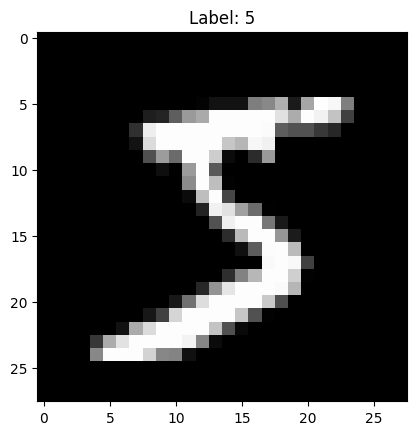

In [6]:
# display MNST image
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Create Test Image  

In [370]:
# test_image is grayscape 3D convert to bw_array first
index = 0
image, label = train_set[index]
test_image = image.squeeze().numpy() #[0:20,:] #or reshape if needed for testing
limit = test_image.mean()
bw_array  = torch.tensor(np.where(test_image < limit, 0, 1))

torch.Size([28, 28])


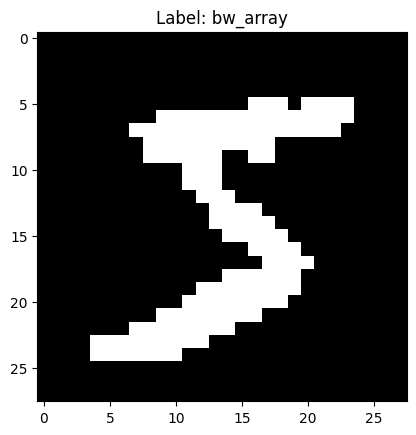

In [369]:
#display bw_array
print(bw_array.shape)
plt.imshow(bw_array, cmap='gray')
plt.title(f"Label: bw_array")
plt.show()

## Run Training

In [504]:
# Init Model, Loss, Optimizer
criterion = nn.MSELoss(reduction='sum')

model = ImageSegmentNet(14,14)
model.set_image(bw_array)
lr=.001
#optimizer only optimizes parameter that are sent to it in arg1
optimizer = torch.optim.AdamW(model.parameters(),
                               lr=lr, betas=(0.9, 0.999), eps=1e-8)

In [505]:
# Train
max_step =30000

for i in range(max_step):
    model.forward()
    #output = criterion(model.xpred, model.xact)
    loss = criterion(model.xpred, model.xact) + criterion(model.ypred, model.yact)
    if(math.isnan(loss)):
        print(f"nan loss at stei {i}")
        break
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if (i%1000 == 0):
        print(f"step {i}: loss: {loss}")
print(f"final step {i}: loss: {loss}")

step 0: loss: 187.5904541015625
step 1000: loss: 53.355594635009766
step 2000: loss: 28.590625762939453
step 3000: loss: 16.846172332763672
step 4000: loss: 15.48480224609375
step 5000: loss: 15.537209510803223
step 6000: loss: 14.282154083251953
step 7000: loss: 16.800487518310547
step 8000: loss: 15.552764892578125
step 9000: loss: 17.882314682006836
step 10000: loss: 14.465694427490234
step 11000: loss: 14.128400802612305
step 12000: loss: 10.979654312133789
step 13000: loss: 12.182236671447754
step 14000: loss: 12.034732818603516
step 15000: loss: 11.644094467163086
step 16000: loss: 13.722761154174805
step 17000: loss: 12.739241600036621
step 18000: loss: 11.19539737701416
step 19000: loss: 11.049018859863281
step 20000: loss: 14.346774101257324
step 21000: loss: 15.17618465423584
step 22000: loss: 15.427663803100586
step 23000: loss: 13.72635269165039
step 24000: loss: 13.287984848022461
step 25000: loss: 13.054922103881836
step 26000: loss: 14.354263305664062
step 27000: loss: 1

torch.Size([28, 14])


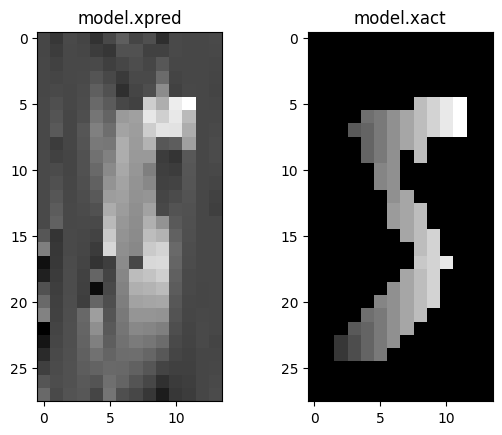

In [506]:
#Commpare xact and xpred
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    print(model.xpred.shape)
    ax1.set_title("model.xpred")
    ax1.imshow(model.xpred, cmap='gray')

ax2.set_title("model.xact")
ax2.imshow(model.xact, cmap='gray')
plt.show()

torch.Size([14, 28])


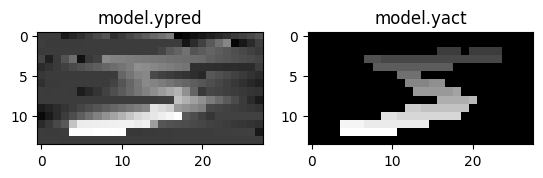

In [507]:
#Commpare xact and xpred
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    print(model.ypred.shape)
    ax1.set_title("model.ypred")
    ax1.imshow(model.ypred, cmap='gray')

ax2.set_title("model.yact")
ax2.imshow(model.yact, cmap='gray')
plt.show()

torch.Size([28, 28])


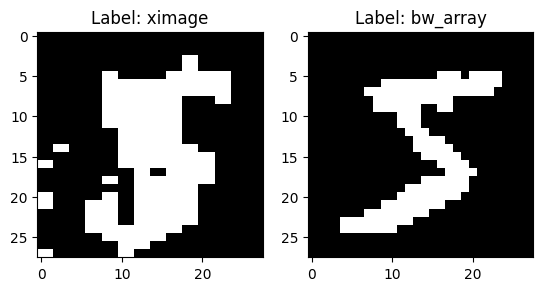

In [508]:
# create ximage and compare
model.create_ximage()

fig, (ax1, ax2) = plt.subplots(1, 2)
print(model.ximage.shape)
ax1.set_title(f"Label: ximage")
#with torch.no_grad():
ax1.imshow(model.ximage.gt(model.ximage.mean()), cmap='gray')

ax2.set_title(f"Label: bw_array")
ax2.imshow(bw_array, cmap='gray')
plt.show()

torch.Size([28, 28])


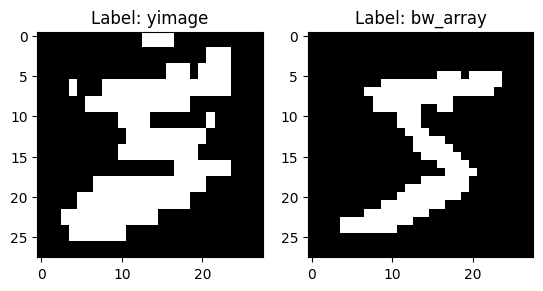

In [509]:
# create yimage and compare
model.create_yimage()

fig, (ax1, ax2) = plt.subplots(1, 2)
print(model.yimage.shape)
ax1.set_title(f"Label: yimage")
#with torch.no_grad():
ax1.imshow(model.yimage.gt(model.yimage.mean()), cmap='gray')

ax2.set_title(f"Label: bw_array")
ax2.imshow(bw_array, cmap='gray')
plt.show()

## Draw  and save graph of the network

In [503]:
# Draw graph
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_ImageSegmentNet_v2_graph")

'model_ImageSegmentNet_v2_graph.pdf'